In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

In [2]:
import tarfile
import os

# Replace with your actual file path
tar_path = "C:/Users/Kanishka K/Downloads\OASIS/oasis_cross-sectional_disc1.tar/oasis_cross-sectional_disc1.tar.gz"
extract_path = "C:/Users/Kanishka K/Downloads/OASIS/oasis_extracted"

# Extract
with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Extraction complete!")


Extraction complete!


Image shape: (256, 256, 128, 1)


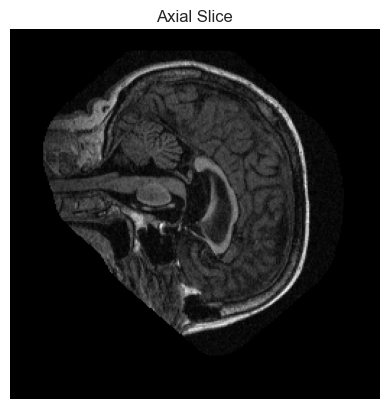

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load Analyze format image (.img + .hdr)
img_path = "C:/Users/Kanishka K/Downloads/OASIS/oasis_extracted/disc1/OAS1_0001_MR1/RAW/OAS1_0001_MR1_mpr-1_anon.hdr"

img = nib.load(img_path)

# Get the image data
img_data = img.get_fdata()
print("Image shape:", img_data.shape)

# Show one slice
plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap='gray')
plt.title("Axial Slice")
plt.axis('off')
plt.show()


In [4]:
nib.save(img, "OAS1_0001_MR1_mpr-1_anon.nii.gz")

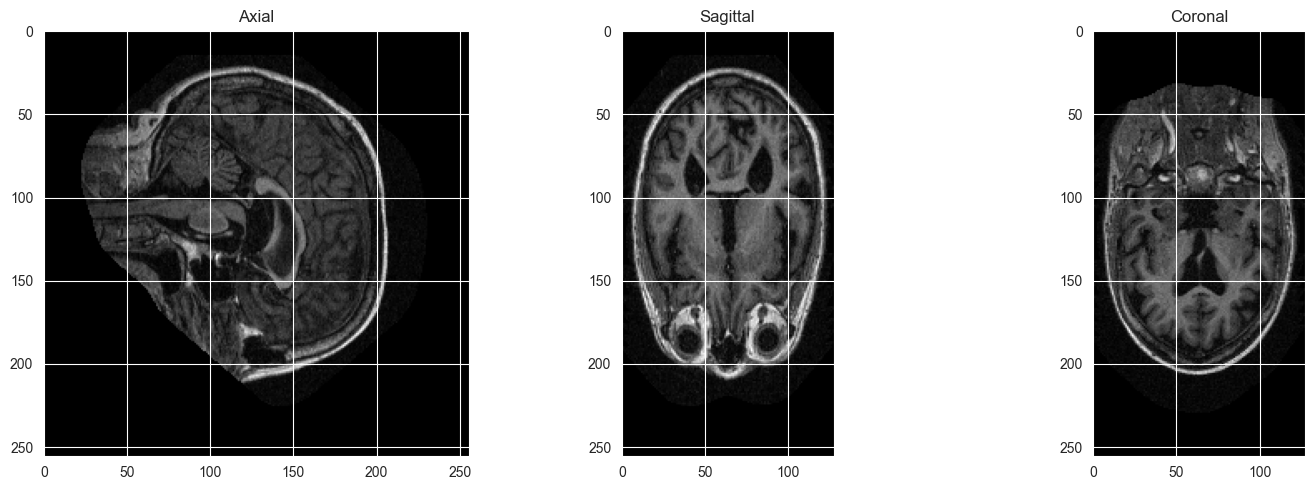

In [5]:
# Visualize Brian slices for sanity check and explore structure

import matplotlib.pyplot as plt
import numpy as np

# Remove extra dimension
img_3d = np.squeeze(img.get_fdata())  # (256, 256, 128)

# Show three orthogonal views
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_3d[:, :, img_3d.shape[2] // 2], cmap='gray')
axes[0].set_title("Axial")

axes[1].imshow(img_3d[:, img_3d.shape[1] // 2, :], cmap='gray')
axes[1].set_title("Sagittal")

axes[2].imshow(img_3d[img_3d.shape[0] // 2, :, :], cmap='gray')
axes[2].set_title("Coronal")

plt.tight_layout()
plt.show()


In [6]:
#normalixe the image intensity , bring the pixel values [0,1] range
img_norm = (img_3d - np.min(img_3d)) / (np.max(img_3d) - np.min(img_3d))


In [7]:
#Resize/downsample for modeling, due to model requirements-
#imagesize like 128* 128*128
from scipy.ndimage import zoom

target_shape = (128, 128, 128)
zoom_factors = [t / s for t, s in zip(target_shape, img_norm.shape)]
img_resized = zoom(img_norm, zoom_factors)

print("Resized shape:", img_resized.shape)


Resized shape: (128, 128, 128)


In [8]:
#Feature Engineering
#Basic
features = {
    "mean_intensity": np.mean(img_resized),
    "std_intensity": np.std(img_resized),
    "max_intensity": np.max(img_resized),
    "min_intensity": np.min(img_resized),
    "nonzero_voxels": np.count_nonzero(img_resized),
    "brain_volume": np.sum(img_resized > 0.1),  # proxy threshold
}

for k, v in features.items():
    print(f"{k}: {v}")


mean_intensity: 0.07404069243715498
std_intensity: 0.13851829442097802
max_intensity: 1.0290713677026666
min_intensity: -0.13160241064249584
nonzero_voxels: 2097152
brain_volume: 496563


In [9]:
hist, bins = np.histogram(img_resized, bins=50, range=(0, 1))
hist_features = hist / np.sum(hist)  # normalize

# Combine with basic features
import numpy as np
feature_vector = np.concatenate([list(features.values()), hist_features])
print("Feature vector length:", len(feature_vector))  # 6 basic + 50 bins = 56


Feature vector length: 56


In [10]:
import pandas as pd

df = pd.DataFrame([feature_vector])
df.columns = [f"f{i}" for i in range(df.shape[1])]
df.columns

Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30',
       'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40',
       'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50',
       'f51', 'f52', 'f53', 'f54', 'f55'],
      dtype='object')

In [11]:
def parse_metadata(txt_path):
    info = {
        "age": None, "sex": None, "cdr": None, "mmse": None, "nwbv": None
    }

    with open(txt_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        # Skip empty lines or lines without colon
        if ":" not in line:
            continue

        key, value = line.split(":", 1)  # split only once
        key = key.strip().lower()
        value = value.strip()

        if key == "age":
            info["age"] = int(value)
        elif key == "m/f":
            info["sex"] = 1 if value.lower() == "female" else 0
        elif key == "cdr":
            info["cdr"] = float(value)
        elif key == "mmse":
            info["mmse"] = float(value)
        elif key == "nwbv":
            info["nwbv"] = float(value)

    return info

meta_path = "C:/Users/Kanishka K/Downloads/OASIS/oasis_extracted/disc1/OAS1_0001_MR1/OAS1_0001_MR1.txt"
metadata = parse_metadata(meta_path)
print(metadata)




{'age': 74, 'sex': 1, 'cdr': 0.0, 'mmse': 29.0, 'nwbv': 0.743}


In [12]:
import os
import numpy as np
import nibabel as nib
from scipy.ndimage import zoom
import pandas as pd

def safe_float(value):
    try:
        return float(value)
    except:
        return np.nan

def parse_metadata(txt_path):
    info = {"age": np.nan, "sex": np.nan, "cdr": np.nan, "mmse": np.nan, "nwbv": np.nan}
    with open(txt_path, "r") as f:
        lines = f.readlines()
    for line in lines:
        if ":" not in line:
            continue
        key, value = line.split(":", 1)
        key = key.strip().lower()
        value = value.strip()

        if not value:  # skip if value is blank
            continue

        if key == "age":
            info["age"] = safe_float(value)
        elif key == "m/f":
            info["sex"] = 1 if value.lower() == "female" else 0
        elif key == "cdr":
            info["cdr"] = safe_float(value)
        elif key == "mmse":
            info["mmse"] = safe_float(value)
        elif key == "nwbv":
            info["nwbv"] = safe_float(value)
    return info

def process_image(img_path):
    img = nib.load(img_path)
    data = np.squeeze(img.get_fdata())

    # Normalize
    data = (data - np.min(data)) / (np.max(data) - np.min(data))

    # Resize
    zoom_factors = [128 / s for s in data.shape]
    data_resized = zoom(data, zoom_factors)

    # Basic features
    basic = [
        np.mean(data_resized),
        np.std(data_resized),
        np.max(data_resized),
        np.min(data_resized),
        np.count_nonzero(data_resized),
        np.sum(data_resized > 0.1)
    ]

    # Histogram
    hist, _ = np.histogram(data_resized, bins=50, range=(0, 1))
    hist = hist / np.sum(hist)

    return np.concatenate([basic, hist])

# Your base directory
base_dir = "C:/Users/Kanishka K/Downloads/OASIS/oasis_extracted/disc1"
all_data = []

for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue

    try:
        # Updated path to image and metadata
        raw_folder = os.path.join(folder_path, "RAW")
        hdr_file = [f for f in os.listdir(raw_folder) if f.endswith(".hdr")][0]
        img_path = os.path.join(raw_folder, hdr_file)
        txt_path = os.path.join(folder_path, f"{folder}.txt")

        # Replace .hdr with .img to load image
        img_path = img_path.replace(".hdr", ".img")

        if not os.path.exists(img_path) or not os.path.exists(txt_path):
            continue

        image_features = process_image(img_path)
        meta = parse_metadata(txt_path)

        full_row = np.concatenate([image_features, list(meta.values())])
        all_data.append(full_row)

    except Exception as e:
        print(f"Skipping {folder} due to error: {e}")

# Column names
feature_names = [f"f{i}" for i in range(56)] + ["age", "sex", "cdr", "mmse", "nwbv"]
df = pd.DataFrame(all_data, columns=feature_names)

print("Final dataset shape:", df.shape)
print(df.head())
print("Before dropping missing:", df.shape)
df = df.dropna(subset=["cdr"])  # Keep only rows with CDR labels
print("After dropping missing:", df.shape)


Final dataset shape: (39, 61)
         f0        f1        f2        f3         f4        f5        f6  \
0  0.074041  0.138518  1.029071 -0.131602  2097152.0  496563.0  0.472671   
1  0.069594  0.140910  1.085676 -0.094137  2097152.0  452682.0  0.537107   
2  0.073063  0.142063  1.050670 -0.122143  2097152.0  473483.0  0.492863   
3  0.080837  0.135404  1.112721 -0.112982  2097152.0  567804.0  0.419784   
4  0.081115  0.127304  1.067832 -0.067934  2097152.0  605998.0  0.416853   

         f7        f8        f9  ...       f51       f52       f53  \
0  0.078896  0.062381  0.026418  ...  0.000059  0.000052  0.000022   
1  0.063202  0.040431  0.020355  ...  0.000030  0.000014  0.000004   
2  0.072924  0.054624  0.025694  ...  0.000088  0.000056  0.000029   
3  0.081491  0.069853  0.029957  ...  0.000054  0.000041  0.000030   
4  0.066010  0.066342  0.031172  ...  0.000013  0.000009  0.000005   

            f54       f55   age  sex  cdr  mmse   nwbv  
0  1.584908e-05  0.000012  74.0  1.

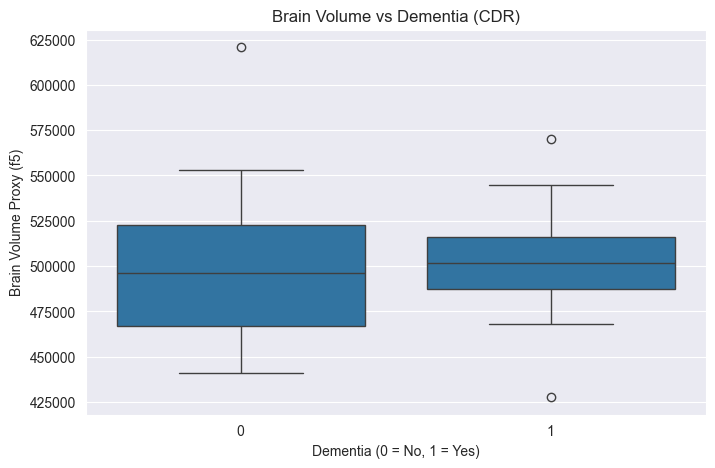

In [13]:
# Visualize Brain features vs CDR
import matplotlib.pyplot as plt
import seaborn as sns

# Focus on only rows with valid CDR
df_cdr = df.dropna(subset=["cdr"])

# Binary label: 0 = healthy, 1 = demented
df_cdr["cdr_binary"] = (df_cdr["cdr"] > 0).astype(int)

# Compare brain volume
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cdr, x="cdr_binary", y="f5")  # f5 = brain volume
plt.xlabel("Dementia (0 = No, 1 = Yes)")
plt.ylabel("Brain Volume Proxy (f5)")
plt.title("Brain Volume vs Dementia (CDR)")
plt.show()


In [14]:
#create the lable for dementia
df_cdr["cdr_binary"] = (df_cdr["cdr"] > 0).astype(int)
df_cdr["cdr_binary"]

0     0
1     0
2     1
8     0
9     0
11    0
13    1
14    1
16    0
17    0
18    0
19    1
20    1
21    1
23    0
25    1
27    0
28    1
29    0
30    0
31    0
32    1
35    1
37    1
38    1
Name: cdr_binary, dtype: int64

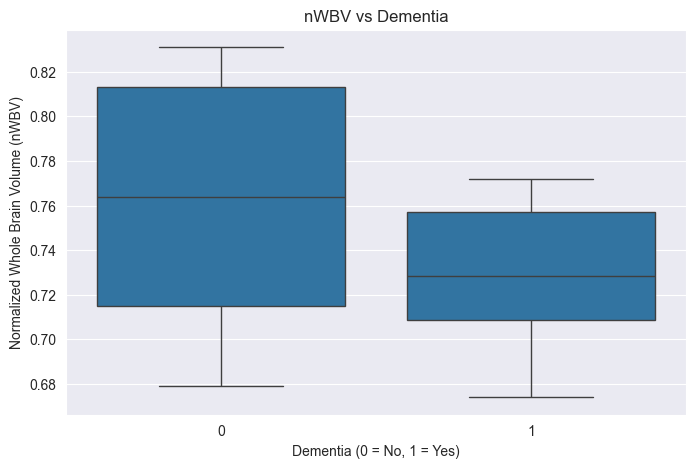

In [15]:
#visualize nWBV vs dementia
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cdr, x="cdr_binary", y="nwbv")
plt.xlabel("Dementia (0 = No, 1 = Yes)")
plt.ylabel("Normalized Whole Brain Volume (nWBV)")
plt.title("nWBV vs Dementia")
plt.show()


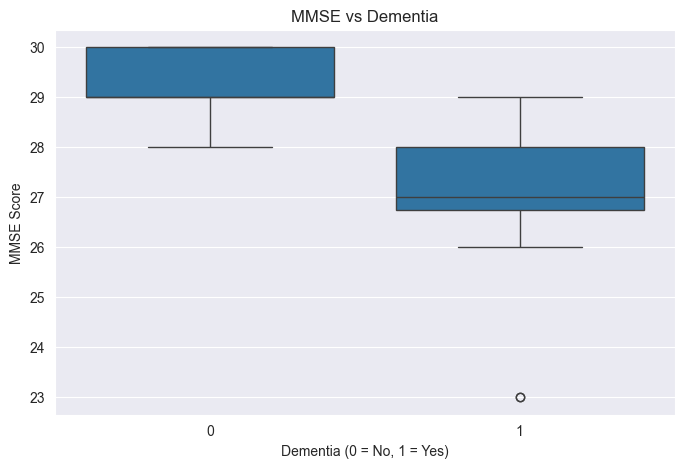

In [16]:
#Visualize MMSE vs Dementia
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cdr, x="cdr_binary", y="mmse")
plt.xlabel("Dementia (0 = No, 1 = Yes)")
plt.ylabel("MMSE Score")
plt.title("MMSE vs Dementia")
plt.show()


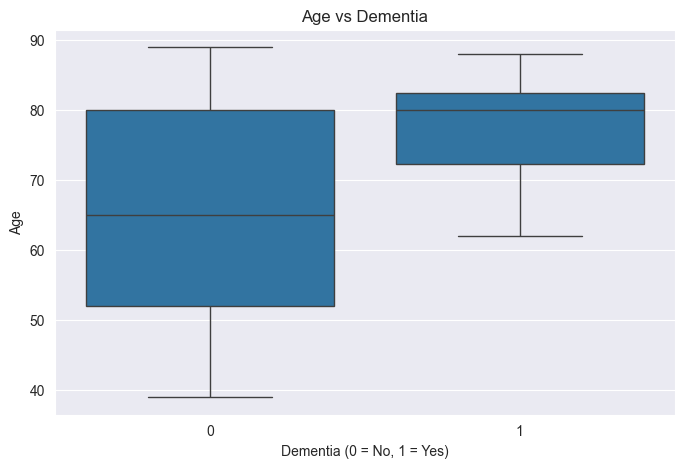

In [17]:
#Visualize Age vs Dementia
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_cdr, x="cdr_binary", y="age")
plt.xlabel("Dementia (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.title("Age vs Dementia")
plt.show()


To predict dementia (CDR Binary classification)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# Define features and label
X = df_cdr[[f"f{i}" for i in range(56)] + ["age", "sex", "nwbv"]]  # include metadata
y = df_cdr["cdr_binary"]  # 0 = no dementia, 1 = dementia

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)


In [19]:
# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)


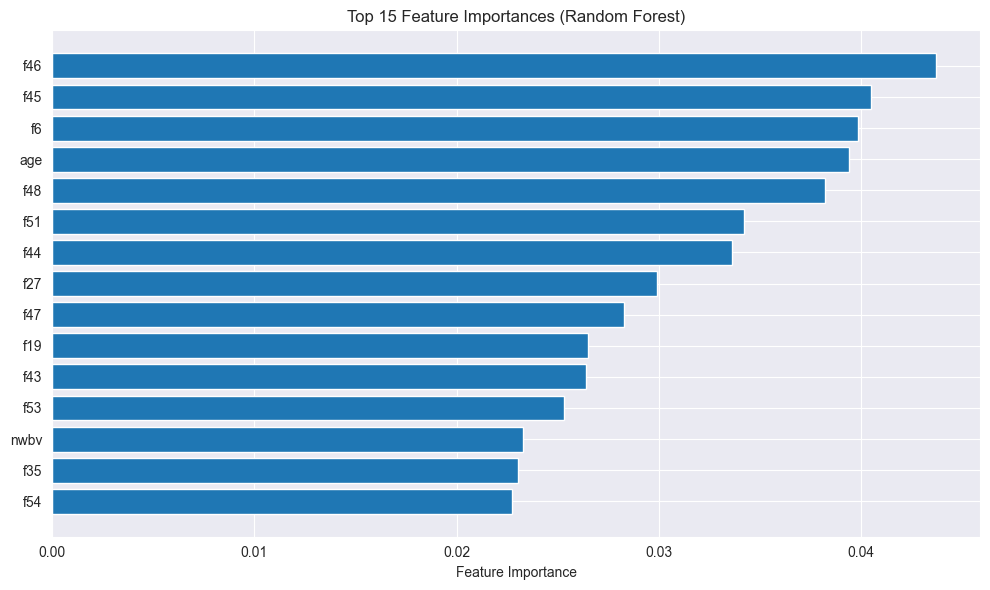

In [20]:
importances = rf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"][:15][::-1], importance_df["Importance"][:15][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.savefig("feature_importance.png")  # Save this for LaTeX
plt.show()

In [21]:
# Performance report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5714285714285714

Classification Report:
               precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.00      0.00      0.00         3

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7


Confusion Matrix:
 [[4 0]
 [3 0]]


C:\Users\Kanishka K\PycharmProjects\AIDeaseEarlyprediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kanishka K\PycharmProjects\AIDeaseEarlyprediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Kanishka K\PycharmProjects\AIDeaseEarlyprediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [22]:
#Use Cross-validation to ensure the stable and fair evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

f1_macro = make_scorer(f1_score, average="macro")
scores = cross_val_score(rf, X, y, cv=5, scoring=f1_macro)
print("Cross-validated F1 (macro):", np.mean(scores))


Cross-validated F1 (macro): 0.7057142857142857


In [23]:
#use Class-weight = "balanced" to imbalance data
rf_balanced = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_balanced.fit(X_train, y_train)
y_pred = rf_balanced.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

           0       0.57      1.00      0.73         4
           1       0.00      0.00      0.00         3

    accuracy                           0.57         7
   macro avg       0.29      0.50      0.36         7
weighted avg       0.33      0.57      0.42         7



In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print(classification_report(y_test, y_pred_lr, zero_division=0))


              precision    recall  f1-score   support

           0       1.00      0.50      0.67         4
           1       0.60      1.00      0.75         3

    accuracy                           0.71         7
   macro avg       0.80      0.75      0.71         7
weighted avg       0.83      0.71      0.70         7



In [25]:
#Checking feature importances
X_with_mmse = df_cdr[[f"f{i}" for i in range(56)] + ["age", "sex", "nwbv", "mmse"]]
rf.fit(X_with_mmse, y)
importances = rf.feature_importances_
for name, val in zip(X_with_mmse.columns, importances):
    print(f"{name}: {val:.4f}")


f0: 0.0121
f1: 0.0064
f2: 0.0153
f3: 0.0235
f4: 0.0000
f5: 0.0026
f6: 0.0120
f7: 0.0056
f8: 0.0135
f9: 0.0103
f10: 0.0215
f11: 0.0068
f12: 0.0195
f13: 0.0079
f14: 0.0117
f15: 0.0137
f16: 0.0212
f17: 0.0125
f18: 0.0061
f19: 0.0069
f20: 0.0161
f21: 0.0069
f22: 0.0306
f23: 0.0167
f24: 0.0123
f25: 0.0533
f26: 0.0154
f27: 0.0221
f28: 0.0109
f29: 0.0139
f30: 0.0100
f31: 0.0141
f32: 0.0446
f33: 0.0121
f34: 0.0151
f35: 0.0103
f36: 0.0098
f37: 0.0079
f38: 0.0032
f39: 0.0155
f40: 0.0053
f41: 0.0071
f42: 0.0089
f43: 0.0140
f44: 0.0042
f45: 0.0074
f46: 0.0322
f47: 0.0126
f48: 0.0495
f49: 0.0135
f50: 0.0255
f51: 0.0261
f52: 0.0183
f53: 0.0269
f54: 0.0277
f55: 0.0300
age: 0.0107
sex: 0.0057
nwbv: 0.0294
mmse: 0.0756


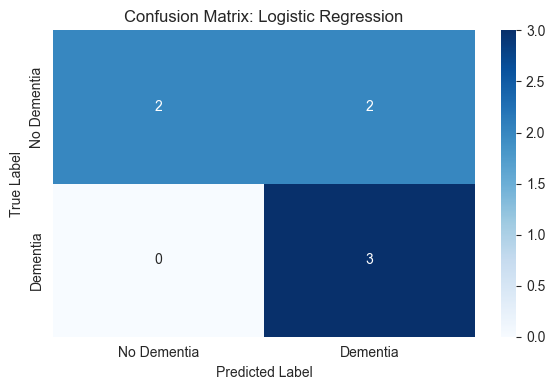

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions again (just to be sure)
y_pred = lr.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Dementia', 'Dementia'],
            yticklabels=['No Dementia', 'Dementia'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Logistic Regression")
plt.tight_layout()
plt.show()


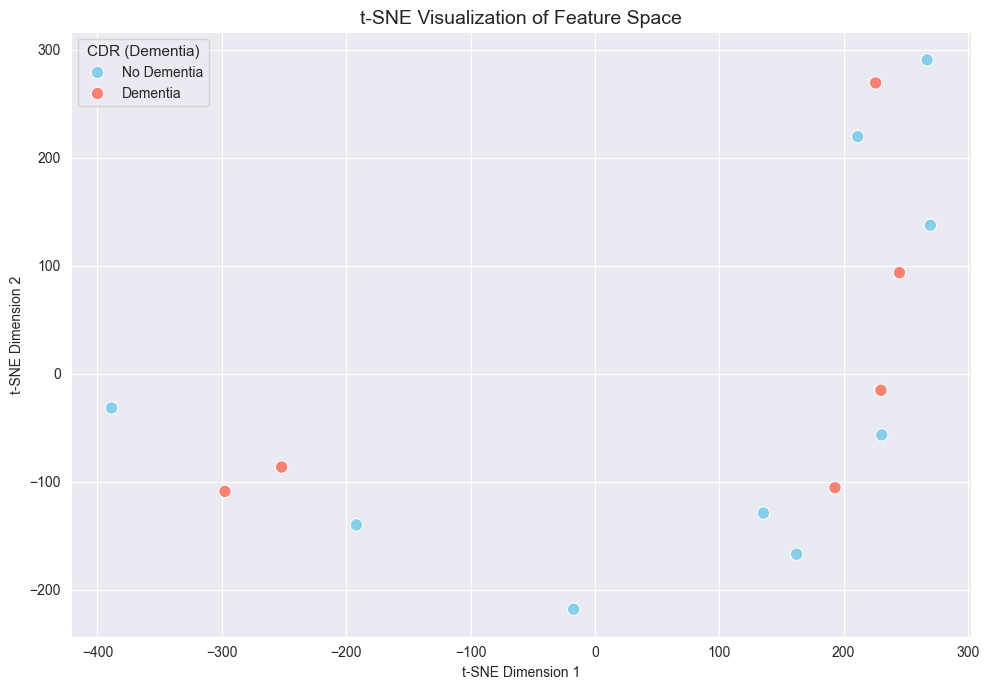

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Fit t-SNE on full feature set
X_tsne = TSNE(n_components=2, perplexity=5, learning_rate=200, random_state=42).fit_transform(X)

# Create a DataFrame to link X_tsne and y
import pandas as pd
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['CDR'] = y.map({0: 'No Dementia', 1: 'Dementia'})  # Convert to string labels

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=tsne_df, x="Dim1", y="Dim2", hue="CDR", palette={"No Dementia": "skyblue", "Dementia": "salmon"}, s=80)
plt.title("t-SNE Visualization of Feature Space", fontsize=14)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="CDR (Dementia)", fontsize=10, title_fontsize=11)
plt.tight_layout()
plt.show()


In [28]:
# Predict MMSE from brain + metadata
X = df_cdr[[f"f{i}" for i in range(56)] + ["age", "sex", "nwbv"]]
y = df_cdr["mmse"]

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MSE: 3.33582857142857
R² Score: 0.25702000000000036
